# Problem Set #1
# BUSN 35150 Winter 2024
# Due Date: Jan 20, 8:30am

(1) Import required packages 

In [116]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import probplot

(2) Provide the path here at which find input data and save the output 

In [117]:
direc = '/Users/baiyu/OneDrive/School work/UChicago (2023 ~ 2024)/Winter 2024/BUSN 35150/PS1'

(3) Set the parameters 

In [118]:
gamma = 5   # (default = 5) relative risk aversion 
sim = 1   # (default = 0) set 1 for simulation, 0 to use actual data
hor = 60    # (default = 60) horizon in months for the long-horizon analysis  

(4) We define a function that will be useful later 

In [119]:
def moving_product(arr, window):
    """
    Calculate the moving product of an array over a specified window size.

    Parameters:
    - arr: NumPy array or list
        The input array for which you want to calculate the moving product.
    - window: int
        The size of the moving window.

    Returns:
    - numpy.ndarray
        An array containing the moving products.
    """
    arr = np.asarray(arr)
    if len(arr) < window:
        raise ValueError("Window size is larger than the array length")

    return np.array([np.prod(arr[i:i+window]) for i in range(len(arr) - window + 1)])

(5) Read actual data or simulate data, depending on the sim parameter that we set above

In [120]:
if sim == 0:
    # Read the data from Excel (make sure you have 'PS1data.xlsx' in the same directory)
    M = pd.read_excel('PS1data.xlsx')
    ret = M['rvwind'].values.reshape(-1,1)
    rf = M['rf'].values.reshape(-1,1)
    data = 'emp'
else:
    # Simulate data 
    rng = np.random.default_rng(1000)  # Set seed for random number generator
    T = 1000000  # Number of time periods to simulate
    e = rng.standard_normal(size = (T,1))  # Random numbers from a standard-normal distribution
    rf = np.exp(np.ones((T, 1)) * 0.04 / 12) - 1  # Risk-free rate
    ret = np.exp(rf + 0.04 / 12 + e * 0.15 / np.sqrt(12)) - 1  # Simulated returns
    data = 'sim'

(6) Calculate moments of monthly returns and the corresponding approximate optimal portfolio solution

In [121]:
m = 12 * np.mean(ret - rf)
v = 12 * np.var(ret - rf, ddof=1)
s = math.sqrt(v)
opt = m / (gamma * v)
results = pd.DataFrame({'Mean': m, 'Variance': v, 'StDev': s, 'Optimal Weight': opt}, index=[''])
print('Based on 1-month returns')
print(pd.DataFrame.round(results, 4))

Based on 1-month returns
   Mean  Variance   StDev  Optimal Weight
  0.052    0.0229  0.1512          0.4547


(7) Compound monthly returns to long-horizon returns, then calculate their moments and the corresponding approximate optimal portfolio solution

In [122]:
compret = moving_product(1 + ret,hor).reshape(-1,1) - 1 
comprf = moving_product(1 + rf,hor).reshape(-1,1) - 1
compm = (12/hor) * np.mean(compret - comprf)
compv = (12/hor) * np.var(compret - comprf, ddof=1)
comps = math.sqrt(compv)
compopt = compm / (gamma * compv)
compresults = pd.DataFrame({'Mean': compm, 'Variance': compv, 'StDev': comps, 'Optimal Weight': compopt}, index=[''])
print('Based on long-horizon returns')
print(pd.DataFrame.round(compresults, 4))

Based on long-horizon returns
    Mean  Variance   StDev  Optimal Weight
  0.0721    0.0598  0.2445          0.2413


(8) Evaluate expected utility numerically to find the optimal risky asset share without relying on an approximation  

In [123]:
# portfolio weights that we try
w = np.arange(0, 1.02, 0.02)
wmat = w.reshape(1,-1)

# utility based on monthly returns for each candidate portfolio weight
W = 1 + rf + (ret - rf) @ wmat
U = (W ** (1 - gamma) - 1) / (1 - gamma)
meanU = np.mean(U,axis = 0)

# utility based on long-horizon returns for each candidate portfolio weight
compW = 1 + comprf + (compret - comprf) @ wmat
compU = (compW ** (1 - gamma) - 1) / (1 - gamma)
meancompU = np.mean(compU, axis = 0)

# find the locations of the maxima 
maxU = np.max(meanU)
ind = np.argmax(meanU)
maxcompU = np.max(meancompU)
indcomp = np.argmax(meancompU)
maxw = w[ind]
maxwcomp = w[indcomp]
print('Optimal weight without approximation, 1-month')
print(maxw) 
print('Optimal weight without approximation, long horizon')
print(maxwcomp)

Optimal weight without approximation, 1-month
0.46
Optimal weight without approximation, long horizon
0.46


(9) Plot the results

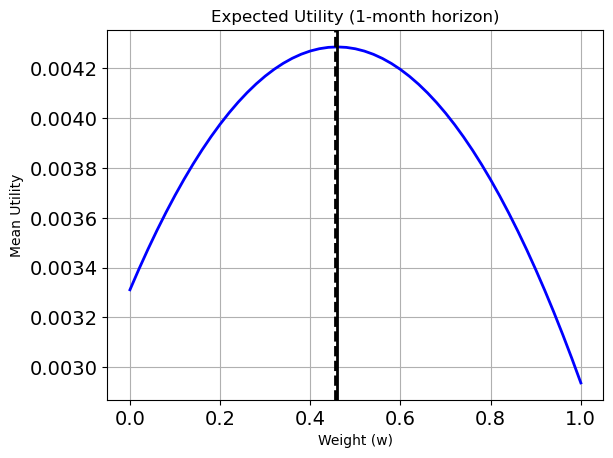

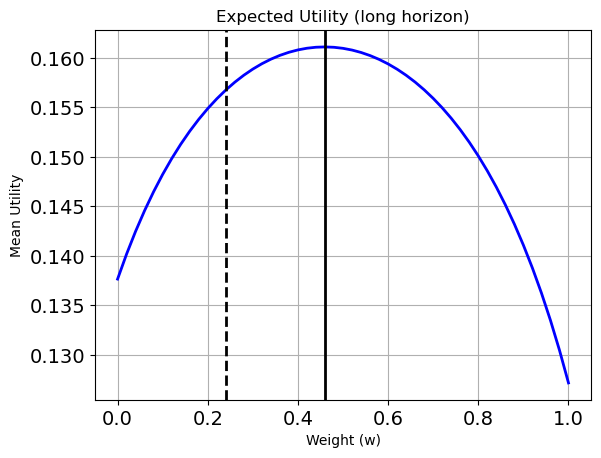

In [124]:
plt.figure()
plt.plot(w, meanU, '-b', linewidth=2)
plt.axvline(maxw, color='k', linestyle='-', linewidth=2)
plt.axvline(opt, color='k', linestyle='--', linewidth=2)
plt.grid(True)
plt.xlabel('Weight (w)')
plt.ylabel('Mean Utility')
plt.title('Expected Utility (1-month horizon)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(direc + data + 'EU1m.pdf', format='pdf')

plt.figure()
plt.plot(w, meancompU, '-b', linewidth=2)
plt.axvline(maxwcomp, color='k', linestyle='-', linewidth=2)
plt.axvline(compopt, color='k', linestyle='--', linewidth=2)
plt.grid(True)
plt.xlabel('Weight (w)')
plt.ylabel('Mean Utility')
plt.title('Expected Utility (long horizon)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(direc + data + 'EULR.pdf', format='pdf')

plt.show()

# Question 1

### (a)
* `ret` stores the stock index return.
* `rf` stores the T-bill yield.


### (b)
The distribution will be log normal because from the code below:

```python
# Simulate data 
    rng = np.random.default_rng(1000)  # Set seed for random number generator
    T = 1000000  # Number of time periods to simulate
    e = rng.standard_normal(size = (T,1))  # Random numbers from a standard-normal distribution
    rf = np.exp(np.ones((T, 1)) * 0.04 / 12) - 1  # Risk-free rate
    ret = np.exp(rf + 0.04 / 12 + e * 0.15 / np.sqrt(12)) - 1  # Simulated returns
    data = 'sim'
```

We know that `ret = np.exp(rf + 0.04 / 12 + e * 0.15 / np.sqrt(12)) - 1` 

is calculated by exponentialize the normally distributed values, which is `e` in this case. Therefore, we would see a log-normal distribution for ret.

### (c)
The reason for multiplying 12 is for annualization. It is a common practice for working with monthly or daily returns to measure the return in a yearly basis.

### (d)
The purpose for multiplying 12/hor is to properly annulize the compounding monthly return. 

For this method, we calculate the compounding return by adding 1 to all the return values of index and risk free rate, and then for each new value, we calculate the compounded product of the preceding 60 values (rolling window of 60 months) by multiplying them together. Once we get all the compound returns with rolling window 60, we subtract 1 to revert to the original form, annulize by 12 (because we are dealing with monthly return) and divide it by 60 (because we calculate each new value by calulate compound returns in the window of 60).

Since using compounding method delivers higher variance compared to simply getting the average of returns and annulize it, and almost the same mean returns, we will end up having a higher weights for the compounding method.

### (e)
* `W` represents the wealth for each candidate portfolio weight.
* `U` represents the utility of each portolio.
* `meanU` represents the mean utility across all candidate portfolio weights.

# Question 2

Based on 1-month returns, we have:
```
Mean  Variance   StDev  Optimal Weight
  0.081    0.0343  0.1853          0.4721
```
Based on long-horizon returns, we have:
```
Mean  Variance   StDev  Optimal Weight
  0.102    0.0674  0.2596          0.3026
```



# Question 3

In [125]:
# Step 1: Read Data
data = pd.read_excel("PS1data.xlsx")
data.set_index("month", inplace=True)

# Step 2: Calculate Portfolio Returns
portfolio_weights = np.array([0.4, 0.6])  # 40% Treasury bills, 60% stock market index
portfolio_returns = np.dot(data[['rf', 'rvwind']], portfolio_weights)
data['Portfolio'] = portfolio_returns

# Step 3: Calculate VaR
alpha = 0.05  # 95% confidence level
var_1month = np.percentile(portfolio_returns, alpha * 100)

# Step 4: Explanation
print(f"One-month 95% VaR of the portfolio: {var_1month:.4f}")


One-month 95% VaR of the portfolio: -0.0452


The one-month 95% VaR of the portfolio of -0.0452 means with the confidence level of 95%, there is a 5% chance that the portfolio's will experience a loss greater or equal to 4.52% over the course of one month.